### Import

In [1]:
import pandas as pd
import numpy as np
import sys
import glob

In [2]:
sys.path.insert(0, '../code/')

In [3]:
from loading_routines import *
from preprocessing import *
from feature_engineering import *
from mov_ampl import *

### Load data

In [4]:
all_files = glob.glob('../data/behavior_AND_personality_dataset/joints/*.xml')
#print all_files

In [5]:
all_subjects_dfs = [load_df_from_xml(f) for f in all_files]

Loaded 0 tracks for "subject6"
Loaded 1000 tracks for "subject6"
Loaded 2000 tracks for "subject6"
Loaded 3000 tracks for "subject6"
Loaded 4000 tracks for "subject6"
Loaded 5000 tracks for "subject6"
Loaded 6000 tracks for "subject6"
Loaded 7000 tracks for "subject6"
Loaded 8000 tracks for "subject6"
Loaded 9000 tracks for "subject6"
Loaded 10000 tracks for "subject6"
Loaded 11000 tracks for "subject6"
Loaded 12000 tracks for "subject6"
Loaded 13000 tracks for "subject6"
Loaded 14000 tracks for "subject6"
Loaded 15000 tracks for "subject6"
Loaded 16000 tracks for "subject6"
Loaded 17000 tracks for "subject6"
Loaded 18000 tracks for "subject6"
Loaded 19000 tracks for "subject6"
Loaded 20000 tracks for "subject6"
Loaded 21000 tracks for "subject6"
Loaded 22000 tracks for "subject6"
Loaded 23000 tracks for "subject6"
Loaded 24000 tracks for "subject6"
Loaded 25000 tracks for "subject6"
Loaded 26000 tracks for "subject6"
Loaded 27000 tracks for "subject6"
Loaded 0 tracks for "subject11"
L

Loaded 0 tracks for "subject15"
Loaded 1000 tracks for "subject15"
Loaded 2000 tracks for "subject15"
Loaded 3000 tracks for "subject15"
Loaded 4000 tracks for "subject15"
Loaded 5000 tracks for "subject15"
Loaded 6000 tracks for "subject15"
Loaded 7000 tracks for "subject15"
Loaded 8000 tracks for "subject15"
Loaded 9000 tracks for "subject15"
Loaded 10000 tracks for "subject15"
Loaded 11000 tracks for "subject15"
Loaded 12000 tracks for "subject15"
Loaded 13000 tracks for "subject15"
Loaded 14000 tracks for "subject15"
Loaded 15000 tracks for "subject15"
Loaded 16000 tracks for "subject15"
Loaded 17000 tracks for "subject15"
Loaded 18000 tracks for "subject15"
Loaded 19000 tracks for "subject15"
Loaded 20000 tracks for "subject15"
Loaded 21000 tracks for "subject15"
Loaded 22000 tracks for "subject15"
Loaded 23000 tracks for "subject15"
Loaded 24000 tracks for "subject15"
Loaded 0 tracks for "subject16"
Loaded 1000 tracks for "subject16"
Loaded 2000 tracks for "subject16"
Loaded 3000

Loaded 18000 tracks for "subject13"
Loaded 19000 tracks for "subject13"
Loaded 20000 tracks for "subject13"
Loaded 21000 tracks for "subject13"
Loaded 22000 tracks for "subject13"
Loaded 23000 tracks for "subject13"
Loaded 24000 tracks for "subject13"
Loaded 0 tracks for "subject5"
Loaded 1000 tracks for "subject5"
Loaded 2000 tracks for "subject5"
Loaded 3000 tracks for "subject5"
Loaded 4000 tracks for "subject5"
Loaded 5000 tracks for "subject5"
Loaded 6000 tracks for "subject5"
Loaded 7000 tracks for "subject5"
Loaded 8000 tracks for "subject5"
Loaded 9000 tracks for "subject5"
Loaded 10000 tracks for "subject5"
Loaded 11000 tracks for "subject5"
Loaded 12000 tracks for "subject5"
Loaded 13000 tracks for "subject5"
Loaded 14000 tracks for "subject5"
Loaded 15000 tracks for "subject5"
Loaded 16000 tracks for "subject5"
Loaded 17000 tracks for "subject5"
Loaded 18000 tracks for "subject5"
Loaded 19000 tracks for "subject5"
Loaded 20000 tracks for "subject5"
Loaded 21000 tracks for "s

## Preprocessing

#### Remove outliers

In [6]:
dfs_prep = [remove_outliers(df) for df in all_subjects_dfs]

In [7]:
df_prep_norm = [normalize_data(df) for df in dfs_prep]

#### Normalization

In [8]:
df_prep_norm[0].head()

,subject,frameId,time,trackingId,head_x,head_y,head_z,neck_x,neck_y,neck_z,...,hipL_z,kneeL_x,kneeL_y,kneeL_z,ankleL_x,ankleL_y,ankleL_z,footL_x,footL_y,footL_z
0,subject6,972,Wed Oct 19 15:55:23 2016,72057594037947129,0.386190,0.173869,0.052419,0.383044,0.244164,0.008968,...,0.068003,0.350522,0.776383,0.078723,0.299130,0.996990,0.100691,0.277487,0.952619,0.144931
1,subject6,974,Wed Oct 19 15:55:23 2016,72057594037947129,0.362022,0.162283,0.062852,0.359109,0.233682,0.021028,...,0.055596,0.319107,0.750228,0.083140,0.290107,0.997701,0.109845,0.272072,0.969132,0.151523
2,subject6,975,Wed Oct 19 15:55:23 2016,72057594037947129,0.350658,0.159470,0.068530,0.345308,0.222619,0.028804,...,0.051110,0.314727,0.751120,0.086213,0.281482,0.997332,0.117542,0.269923,0.971429,0.158297
3,subject6,979,Wed Oct 19 15:55:23 2016,72057594037947129,0.315967,0.154573,0.096478,0.310125,0.211045,0.060574,...,0.059047,0.278473,0.760499,0.084163,0.255411,0.901713,0.108243,0.262629,0.921586,0.079632
4,subject6,980,Wed Oct 19 15:55:23 2016,72057594037947129,0.310076,0.153182,0.103464,0.298127,0.210389,0.070537,...,0.065435,0.275293,0.745896,0.093535,0.275546,0.910628,0.091468,0.276045,0.904064,0.133296


#### Detect frames with little movement

* either of the head coordinates in a sequence moves more than 0.03

In [10]:
#is a list of lists
# "little movement" not little enough?
dfs_little_movement = [get_sequences_with_little_movement(df, variables_to_check=['head_x', 'head_y', 'head_z'], max_mov=0.03) for df in df_prep_norm]

Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds
Setting out of bounds


In [11]:
for df in dfs_little_movement:
    print 'Length of sequences with little movement for ', df[0]['subject'].iloc[0]
    print '*'*5
    for d in df:
        print(len(d))

Length of sequences with little movement for  subject6
*****
74
63
85
80
94
60
72
116
127
98
108
121
133
101
63
394
63
60
94
93
221
79
133
74
93
104
100
211
88
68
155
239
60
690
208
106
82
213
1843
210
301
171
626
167
83
349
367
583
119
122
Length of sequences with little movement for  subject11
*****
83
191
62
92
60
130
83
80
62
66
1041
78
2170
85
320
338
211
179
128
61
61
72
64
69
67
85
252
159
338
73
80
1122
76
2304
81
825
76
1153
278
Length of sequences with little movement for  subject9
*****
107
80
75
139
74
112
83
69
87
62
121
154
64
73
83
100
138
66
87
61
74
223
214
78
151
237
311
64
99
141
100
104
76
115
75
91
60
197
64
169
128
120
137
74
65
109
133
92
285
255
964
201
2235
754
717
403
Length of sequences with little movement for  subject8
*****
324
124
139
98
76
66
65
76
222
166
111
175
84
102
73
68
86
123
84
80
266
169
134
225
176
78
123
70
68
76
179
197
123
75
168
67
137
309
62
145
243
104
77
136
65
71
97
999
77
166
145
67
269
415
166
261
361
93
391
78
246
96
304
1130
80
62


In [12]:
#dfs_little_movement[-1][-1]

In [13]:
dfs_little_movement[0][0].head()

,subject,frameId,time,trackingId,head_x,head_y,head_z,neck_x,neck_y,neck_z,...,hipL_z,kneeL_x,kneeL_y,kneeL_z,ankleL_x,ankleL_y,ankleL_z,footL_x,footL_y,footL_z
297,subject6,1720,Wed Oct 19 15:55:49 2016,72057594037947165,0.126027,0.746373,0.121460,0.137123,0.702533,0.116519,...,0.235858,0.193983,0.688000,0.205742,0.175493,0.825526,0.258049,0.188064,0.824960,0.249680
298,subject6,1721,Wed Oct 19 15:55:49 2016,72057594037947165,0.125926,0.749693,0.121489,0.137171,0.703586,0.116467,...,0.236462,0.196562,0.666692,0.200300,0.174348,0.811697,0.249532,0.187271,0.811235,0.240974
299,subject6,1722,Wed Oct 19 15:55:49 2016,72057594037947165,0.125685,0.753812,0.121129,0.136980,0.706924,0.116635,...,0.237470,0.198818,0.648911,0.199719,0.174893,0.798731,0.247267,0.189859,0.796482,0.237417
300,subject6,1723,Wed Oct 19 15:55:49 2016,72057594037947165,0.125581,0.755220,0.120814,0.136937,0.709419,0.116739,...,0.239671,0.198595,0.647026,0.200240,0.174853,0.797538,0.247427,0.189699,0.795898,0.238093
301,subject6,1724,Wed Oct 19 15:55:49 2016,72057594037947165,0.125655,0.757153,0.120773,0.137155,0.712688,0.116592,...,0.265796,0.195875,0.634741,0.209990,0.174305,0.793712,0.250264,0.192858,0.791592,0.244523


In [14]:
all_little_movement_per_person = [pd.concat(df) for df in dfs_little_movement]

In [15]:
for df in all_little_movement_per_person:
    print len(df)

9964
12755
11150
11388
7570
9471
10990
8298
7221
9714
32065
6472
7397
12869
2741
9478
5713
3937
10628


### Extract Posture Features for upper joints

In [16]:
upper_joints = ['head_x', 'head_y', 'head_z',
              'neck_x', 'neck_y', 'neck_z',
              'spineShoulder_x', 'spineShoulder_y', 'spineShoulder_z',
              'shoulderR_x', 'shoulderR_y', 'shoulderR_z',
              'elbowR_x', 'elbowR_y', 'elbowR_z',
              'wristR_x', 'wristR_y', 'wristR_z',
              'handR_x', 'handR_y', 'handR_z',
              'shoulderL_x', 'shoulderL_y', 'shoulderL_z',
              'elbowL_x', 'elbowL_y', 'elbowL_z',
              'wristL_x', 'wristL_y', 'wristL_z',
              'handL_x', 'handL_y', 'handL_z']

In [17]:
posture_per_person = [calculate_joint_differences(df, only_for_columns=upper_joints) for df in all_little_movement_per_person]

In [18]:
print 'Total posture features: ', len(posture_per_person[0].columns)

Total posture features:  165


In [19]:
posture_per_person[0].head()

,elbowL_x-elbowR_x,elbowL_x-handL_x,elbowL_y-handL_y,elbowL_z-elbowR_z,elbowL_z-handL_z,elbowL_z-wristL_z,elbowR_x-handL_x,elbowR_y-elbowL_y,elbowR_y-handL_y,elbowR_z-handL_z,...,wristR_y-elbowL_y,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z
297,0.016359,0.025776,-0.190232,0.0,-0.076197,-0.072223,0.009417,0.0,-0.190232,-0.076197,...,0.071215,0.071215,-0.119017,-0.083172,-0.122333,-0.003463,-0.003463,-0.079660,0.042085,-0.075685
298,0.016592,0.025094,-0.193602,0.0,-0.074814,-0.071353,0.008502,0.0,-0.193602,-0.074814,...,0.072086,0.072086,-0.121515,-0.086334,-0.124911,-0.003094,-0.003094,-0.077909,0.043154,-0.074447
299,0.049455,0.025741,-0.243302,0.0,-0.060340,-0.055882,-0.023714,0.0,-0.243302,-0.060340,...,0.089393,0.089393,-0.153909,-0.122049,-0.158537,-0.010588,-0.010588,-0.070928,0.050643,-0.066469
300,0.045395,0.025252,-0.215897,0.0,-0.066038,-0.061566,-0.020143,0.0,-0.215897,-0.066038,...,0.088291,0.088291,-0.127605,-0.121180,-0.138248,-0.010234,-0.010234,-0.076271,0.050293,-0.071800
301,0.042850,0.024483,-0.212908,0.0,-0.066008,-0.057371,-0.018367,0.0,-0.212908,-0.066008,...,0.087517,0.087517,-0.125391,-0.123351,-0.149468,-0.009771,-0.009771,-0.075780,0.050838,-0.067142


In [50]:
mean_posture_features = []
for i, df in enumerate(posture_per_person):
    pos_mean = pd.DataFrame([df.mean().values], columns=df.mean().index)
    subject = all_little_movement_per_person[i].iloc[0]['subject']
    pos_mean['subject'] = subject
    mean_posture_features.append(pos_mean)

In [53]:
mean_posture_features[0]

,elbowL_x-elbowR_x,elbowL_x-handL_x,elbowL_y-handL_y,elbowL_z-elbowR_z,elbowL_z-handL_z,elbowL_z-wristL_z,elbowR_x-handL_x,elbowR_y-elbowL_y,elbowR_y-handL_y,elbowR_z-handL_z,...,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z,subject
0,-0.009477,-0.03332,-0.015475,0.0,0.109219,0.103285,-0.023843,0.0,-0.015475,0.109219,...,-0.053048,-0.068523,-0.137412,-0.071556,-0.070646,-0.070646,0.038572,-0.049227,0.032639,subject6


In [65]:
posture_feat_df = pd.concat(mean_posture_features)

#### Look at specific set of posture features


In [ ]:
specific_posture = ['head_'+coord+'-shoulderL_'+coord for coord in ['x', 'y', 'z']]+['shoulderR_'+coord+'-head_'+coord for coord in ['x', 'y', 'z']]+['shoulderR_'+coord+'-shoulderL_'+coord for coord in ['x', 'y', 'z']]+['wristR_'+coord+'-neck_'+coord for coord in ['x', 'y', 'z']]
specific_posture

In [ ]:
#get subject number back (was lost while calculating posture features)
for i, df in enumerate(posture_per_person):
    subject = all_little_movement_per_person[i].iloc[0]['subject']
    df['subject'] = [subject]*len(df)

In [ ]:
for df in posture_per_person:
    print'Means for subject ', df['subject'].iloc[0]
    print '*'*5
    print df[specific_posture].mean()

In [ ]:
import matplotlib.pyplot as plt
len(posture_per_person[0][specific_posture])

In [ ]:
big_posture_df = pd.concat(posture_per_person)
len(big_posture_df)

In [ ]:
#fig=plt.figure(figsize=(20, 20))
big_posture_df.boxplot(column = specific_posture,
                       by='subject', figsize=(20,20))
plt.show()

## Extract Movement Amplitude features

In [54]:
amplitude_feature_dfs = []
for df in all_subjects_dfs:
    amp_df = mov_amplitude(df, s_joint='wristR', m_joint='neck')
    amp_df['subject'] = df['subject'].iloc[0]
    amplitude_feature_dfs.append(amp_df)

In [62]:
amplitude_df = pd.concat(amplitude_feature_dfs).reset_index()
amplitude_df.drop('index', axis=1, inplace=True)
amplitude_df.head()
#amplitude_df.join(mean_posture_features, on='subject')

,ampl_freq_wristR_x-neck_x,ampl_freq_wristR_y-neck_y,ampl_freq_wristR_z-neck_z,ampl_max_wristR_x-neck_x,ampl_max_wristR_y-neck_y,ampl_max_wristR_z-neck_z,ampl_min_wristR_x-neck_x,ampl_min_wristR_y-neck_y,ampl_min_wristR_z-neck_z,ampl_mean_wristR_x-neck_x,ampl_mean_wristR_y-neck_y,ampl_mean_wristR_z-neck_z,subject
0,0.035853,0.001453,0.005329,0.140970,0.653866,0.266019,0.000045,0.000458,0.000174,0.039906,0.159316,0.059245,subject6
1,0.003861,0.014157,0.006006,0.205669,0.480024,0.279194,0.000017,0.000024,0.000002,0.041630,0.117861,0.047757,subject11
2,0.023397,0.016942,0.023397,0.186307,0.473032,0.236006,0.000002,0.000020,0.000021,0.047554,0.134056,0.062746,subject9
3,0.005173,0.026661,0.015917,0.236767,0.391055,0.196598,0.000023,0.000004,0.000014,0.056207,0.095790,0.048815,subject8
4,0.002119,0.030720,0.004767,0.223123,0.458909,0.262678,0.000044,0.000024,0.000071,0.038082,0.135942,0.059362,subject4


In [74]:
all_features = amplitude_df.merge(posture_feat_df, on='subject')
all_features.head()

,ampl_freq_wristR_x-neck_x,ampl_freq_wristR_y-neck_y,ampl_freq_wristR_z-neck_z,ampl_max_wristR_x-neck_x,ampl_max_wristR_y-neck_y,ampl_max_wristR_z-neck_z,ampl_min_wristR_x-neck_x,ampl_min_wristR_y-neck_y,ampl_min_wristR_z-neck_z,ampl_mean_wristR_x-neck_x,...,wristR_y-elbowL_y,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z
0,0.035853,0.001453,0.005329,0.140970,0.653866,0.266019,0.000045,0.000458,0.000174,0.039906,...,-0.053048,-0.053048,-0.068523,-0.137412,-0.071556,-0.070646,-0.070646,0.038572,-0.049227,0.032639
1,0.003861,0.014157,0.006006,0.205669,0.480024,0.279194,0.000017,0.000024,0.000002,0.041630,...,-0.081200,-0.081200,-0.075823,-0.097372,-0.087855,-0.082685,-0.082685,0.051311,-0.003898,0.037195
2,0.023397,0.016942,0.023397,0.186307,0.473032,0.236006,0.000002,0.000020,0.000021,0.047554,...,-0.017208,-0.017208,0.008290,-0.085066,0.008914,-0.097846,-0.097846,0.007456,-0.046036,-0.003832
3,0.005173,0.026661,0.015917,0.236767,0.391055,0.196598,0.000023,0.000004,0.000014,0.056207,...,-0.000121,-0.000121,0.014498,-0.044815,0.014405,-0.056156,-0.056156,-0.010477,-0.030065,0.001028
4,0.002119,0.030720,0.004767,0.223123,0.458909,0.262678,0.000044,0.000024,0.000071,0.038082,...,-0.061990,-0.061990,-0.060879,-0.077953,-0.063477,-0.028447,-0.028447,0.008349,-0.014457,0.000248


In [83]:
all_features.corr()

,ampl_freq_wristR_x-neck_x,ampl_freq_wristR_y-neck_y,ampl_freq_wristR_z-neck_z,ampl_max_wristR_x-neck_x,ampl_max_wristR_y-neck_y,ampl_max_wristR_z-neck_z,ampl_min_wristR_x-neck_x,ampl_min_wristR_y-neck_y,ampl_min_wristR_z-neck_z,ampl_mean_wristR_x-neck_x,...,wristR_y-elbowL_y,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z
ampl_freq_wristR_x-neck_x,1.000000,-0.147039,0.071048,-0.544961,0.688923,0.147222,0.391784,0.061225,0.215655,0.132593,...,-0.175598,-0.175598,-0.159168,-0.235931,-0.174228,-0.164769,-0.164769,0.065511,-0.232117,-0.069621
ampl_freq_wristR_y-neck_y,-0.147039,1.000000,0.130911,0.050190,-0.038681,0.142682,0.116117,-0.116614,-0.010414,0.126324,...,0.020625,0.020625,-0.459672,0.222126,-0.358072,0.227473,0.227473,-0.562880,-0.027476,-0.475376
ampl_freq_wristR_z-neck_z,0.071048,0.130911,1.000000,0.325382,0.097221,-0.455285,-0.185505,0.270632,0.171348,0.428752,...,0.292149,0.292149,0.274604,0.245141,0.259449,-0.271517,-0.271517,-0.367197,-0.262517,-0.351700
ampl_max_wristR_x-neck_x,-0.544961,0.050190,0.325382,1.000000,-0.582284,-0.163573,-0.391789,-0.250660,-0.211208,0.466232,...,0.306330,0.306330,0.337184,0.293977,0.367184,0.087168,0.087168,0.037713,0.294112,0.172485
ampl_max_wristR_y-neck_y,0.688923,-0.038681,0.097221,-0.582284,1.000000,0.360584,0.162548,0.343373,0.578852,-0.128236,...,-0.550696,-0.550696,-0.514327,-0.510506,-0.608417,-0.357166,-0.357166,-0.066337,-0.481362,-0.197027
ampl_max_wristR_z-neck_z,0.147222,0.142682,-0.455285,-0.163573,0.360584,1.000000,-0.108738,-0.181564,0.033700,-0.386257,...,-0.588172,-0.588172,-0.664828,-0.485325,-0.686262,-0.053676,-0.053676,0.137193,-0.134432,0.043609
ampl_min_wristR_x-neck_x,0.391784,0.116117,-0.185505,-0.391789,0.162548,-0.108738,1.000000,-0.212619,-0.173469,-0.009270,...,0.307382,0.307382,0.022088,0.330613,0.059515,-0.051428,-0.051428,-0.012312,0.043141,-0.211062
ampl_min_wristR_y-neck_y,0.061225,-0.116614,0.270632,-0.250660,0.343373,-0.181564,-0.212619,1.000000,0.748748,0.041640,...,-0.017026,-0.017026,0.143495,0.115019,0.056333,-0.266122,-0.266122,0.134786,-0.319831,0.166486
ampl_min_wristR_z-neck_z,0.215655,-0.010414,0.171348,-0.211208,0.578852,0.033700,-0.173469,0.748748,1.000000,0.050488,...,-0.142880,-0.142880,-0.145333,-0.132106,-0.199174,-0.237163,-0.237163,0.047792,-0.361050,0.089010
ampl_mean_wristR_x-neck_x,0.132593,0.126324,0.428752,0.466232,-0.128236,-0.386257,-0.009270,0.041640,0.050488,1.000000,...,0.295426,0.295426,0.360567,0.419878,0.370980,-0.146401,-0.146401,0.204512,0.194701,0.327027


In [77]:
import seaborn as sns
%matplotlib inline

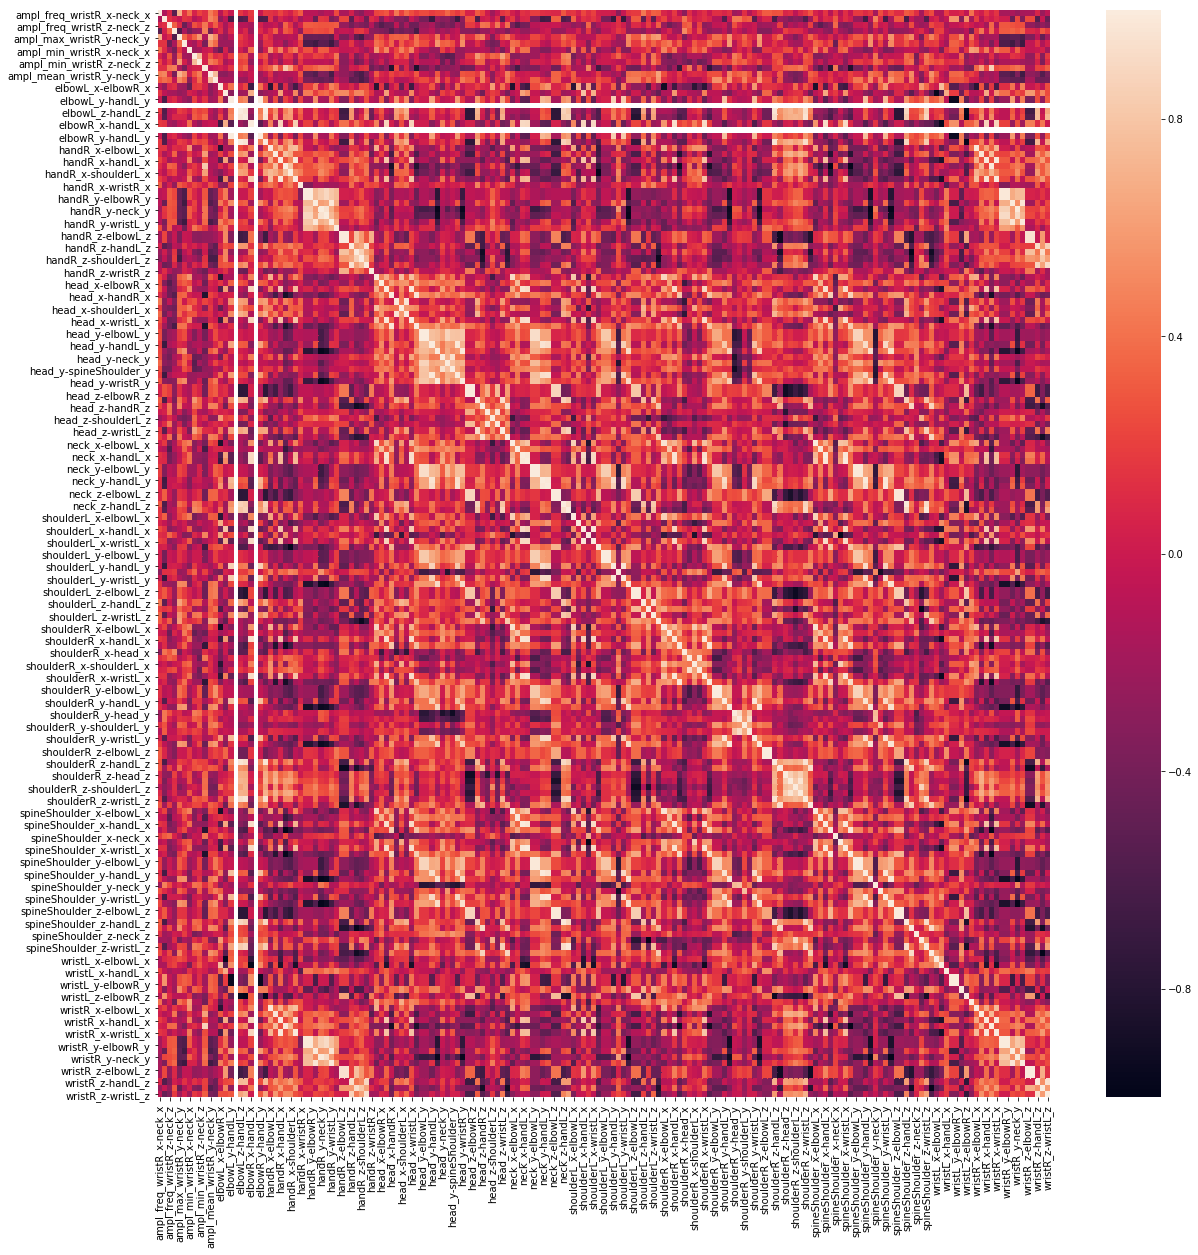

In [81]:
fig=plt.figure(figsize=(20, 20))
sns.heatmap(all_features.corr())